In [1]:

import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
''
import warnings

warnings.filterwarnings('ignore')

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 테이블 현황 파악을 위한 함수 
def summary_table(table):
    df = pd.DataFrame()
    for i in table.columns:
        name = i
        dtype = table[i].dtype.name
        null = table[i].isnull().sum()
        act = table.shape[0] - null
        unique = len(table[i].unique())
        data = {'name': name, 'dtype': dtype, 'null': null, 'act': act, 'unique': unique}
        df = df.append(data, ignore_index=True)
    return df

### 데이터 불러오기

In [3]:
# train 
detail_train = pd.read_csv('coupon_data_project2/coupon_detail_train.csv_translated_en.csv', parse_dates=['I_DATE'])
visit_train = pd.read_csv('coupon_data_project2/coupon_visit_train.csv', parse_dates=['I_DATE'])

area_train = pd.read_csv('coupon_data_project2/coupon_area_train.csv_translated_en.csv')
coupon_list_train = pd.read_csv('coupon_data_project2/coupon_list_train.csv_translated_en.csv', parse_dates=['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND'])

# base data
prefecture_location = pd.read_csv('coupon_data_project2/prefecture_locations.csv_translated_en.csv')
user_list = pd.read_csv('coupon_data_project2/user_list.csv_translated_en.csv', parse_dates=['WITHDRAW_DATE', 'REG_DATE'])

# test data
area_test = pd.read_csv('coupon_data_project2/coupon_area_test.csv_translated_en.csv')
coupon_list_test = pd.read_csv('coupon_data_project2/coupon_list_test.csv_translated_en.csv')

# submisiion
submission = pd.read_csv('coupon_data_project2/sample_submission.csv')

### area_train 분석

In [4]:
# PREF_NAME 에서 Prefecture 제외
area_train.PREF_NAME = area_train.PREF_NAME.str.replace(' Prefecture', '').str.replace(' prefecture', '')

In [5]:
area_train[:1]

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,Saitama,Saitama,6b263844241eea98c5a97f1335ea82af


- area / detail / coupon 에 분포되어 있는 SMALL_AREA가 동일한지 검증하였음

In [6]:
area = area_train.SMALL_AREA_NAME.unique()
detail = detail_train.SMALL_AREA_NAME.unique()
coupon = coupon_list_train.SMALL_AREA_NAME.unique()
pd.DataFrame({"area":area, "detail":detail, "coupon":coupon})[:2]

,area,coupon,detail
0,Saitama,Saitama,Hyogo
1,Chiba,Chiba,"Ginza Shinbashi, Tokyo, Ueno"


In [7]:
area_train.pivot_table(index=['PREF_NAME','SMALL_AREA_NAME'], values='COUPON_ID_hash', aggfunc='count')

,,COUPON_ID_hash
PREF_NAME,SMALL_AREA_NAME,
Aichi,Aichi,3275
Akita,Akita,2248
Aomori,Aomori,2264
Chiba,Chiba,2922
Ehime,Ehime,2254
Fukui,Fukui,2141
Fukuoka,Fukuoka,3135
Fukushima,Fukushima,2215
Gifu,Gifu,2682


- Tokyo, Osaka, Kanagawa 를 제외하고는 PREF_NAME과 SMALL_AREA_NAME이 같음

In [8]:
area_train['comparison'] = np.where(area_train.PREF_NAME == area_train.SMALL_AREA_NAME, 'same', 'diff')
area_train.comparison.value_counts()

same    100700
diff     37485
Name: comparison, dtype: int64

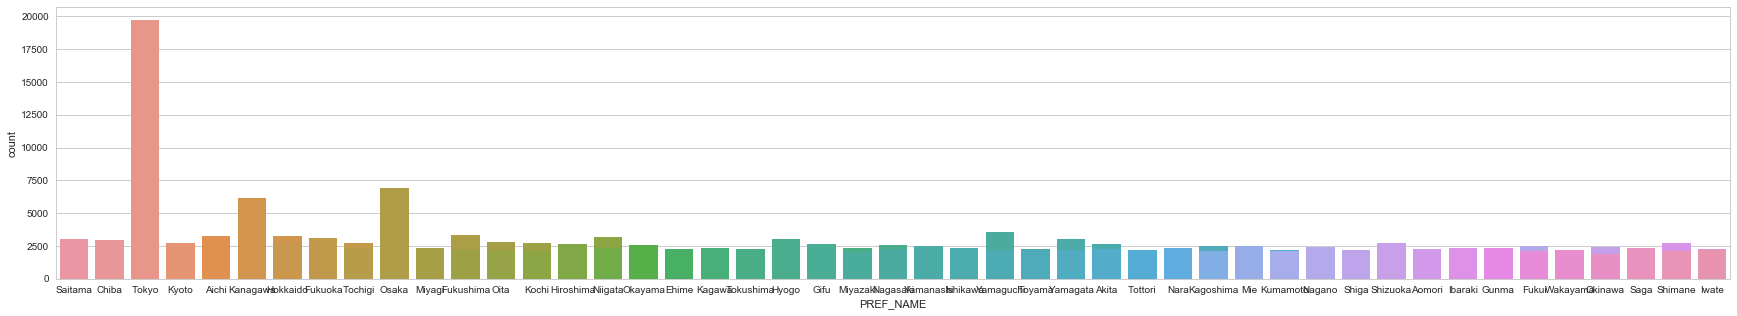

In [9]:
plt.figure(figsize = (30,5))
sns.countplot(area_train.SMALL_AREA_NAME)
sns.countplot(area_train.PREF_NAME)

### coupon_list

In [10]:
summary_table(coupon_list_train).pivot_table(index=['dtype', 'name'])

act    null   unique
dtype          name                                                
datetime64[ns] DISPEND                     19413.0     0.0    373.0
               DISPFROM                    19413.0     0.0    378.0
               VALIDEND                    13266.0  6147.0    515.0
               VALIDFROM                   13266.0  6147.0    377.0
float64        USABLE_DATE_BEFORE_HOLIDAY  12408.0  7005.0      4.0
               USABLE_DATE_FRI             12408.0  7005.0      4.0
               USABLE_DATE_HOLIDAY         12408.0  7005.0      4.0
               USABLE_DATE_MON             12408.0  7005.0      4.0
               USABLE_DATE_SAT             12408.0  7005.0      4.0
               USABLE_DATE_SUN             12408.0  7005.0      4.0
               USABLE_DATE_THU             12408.0  7005.0      4.0
               USABLE_DATE_TUE             12408.0  7005.0      4.0
               USABLE_DATE_WED             12408.0  7005.0      4.0
               VALIDPERIOD                 13266.0  6147.0    181.0
int64          CATALOG_PRICE               19413.0     0.0   2415.0
               DISCOUNT_PRICE              19413.0     0.0   1115.0
               DISPPERIOD                  19413.0     0.0     18.0
               PRICE_RATE                  19413.0     0.0     71.0
object         CAPSULE_TEXT                19413.0     0.0     24.0
               COUPON_ID_hash              19413.0     0.0  19413.0
               GENRE_NAME                  19413.0     0.0     13.0
               SMALL_AREA_NAME             19413.0     0.0     55.0
               ken_name                    19413.0     0.0     47.0
               large_area_name             19413.0     0.0      9.0

In [11]:
coupon_numeric = [x for x in coupon_list_train.columns if coupon_list_train[x].dtype == 'float64' or coupon_list_train[x].dtype == 'int64']
coupon_cat = [x for x in coupon_list_train.columns if coupon_list_train[x].dtype == 'object']
coupon_cat.remove('COUPON_ID_hash')

In [12]:
# 유효기간이 있는 경우가 없는 경우로 나눠 보고자 함.
coupon_list_train['VALID'] = np.where(coupon_list_train['USABLE_DATE_FRI'].isnull(), 'no', 'yes')

In [13]:
filtered = coupon_list_train[coupon_list_train['VALID'] == 'yes']

In [14]:
# 유효기간의 경우 100일 이상이 많았음
# 세일한 기간은 대략 10일미만 , 3일이 제일 많았고 14이상은 거의 없다고 봐도 됨.
# 그렇다고해서 함부로 아웃라이어로 취급할 수는 없음. 그 쿠폰의 구매량이 많았다면 기간이 의미가 있다고 봐야 함.
# 기간이 긴 쿠폰만을 샘플링해서, 할인 기간 중 초반 몇 % 대에서 많이 구매를 했는지 파악해야 함
filtered_validperiod = coupon_list_train.VALIDPERIOD[(coupon_list_train.VALIDPERIOD >= 1)]
filtered_dispperiod = coupon_list_train.DISPPERIOD[(coupon_list_train.DISPPERIOD) <= 8]

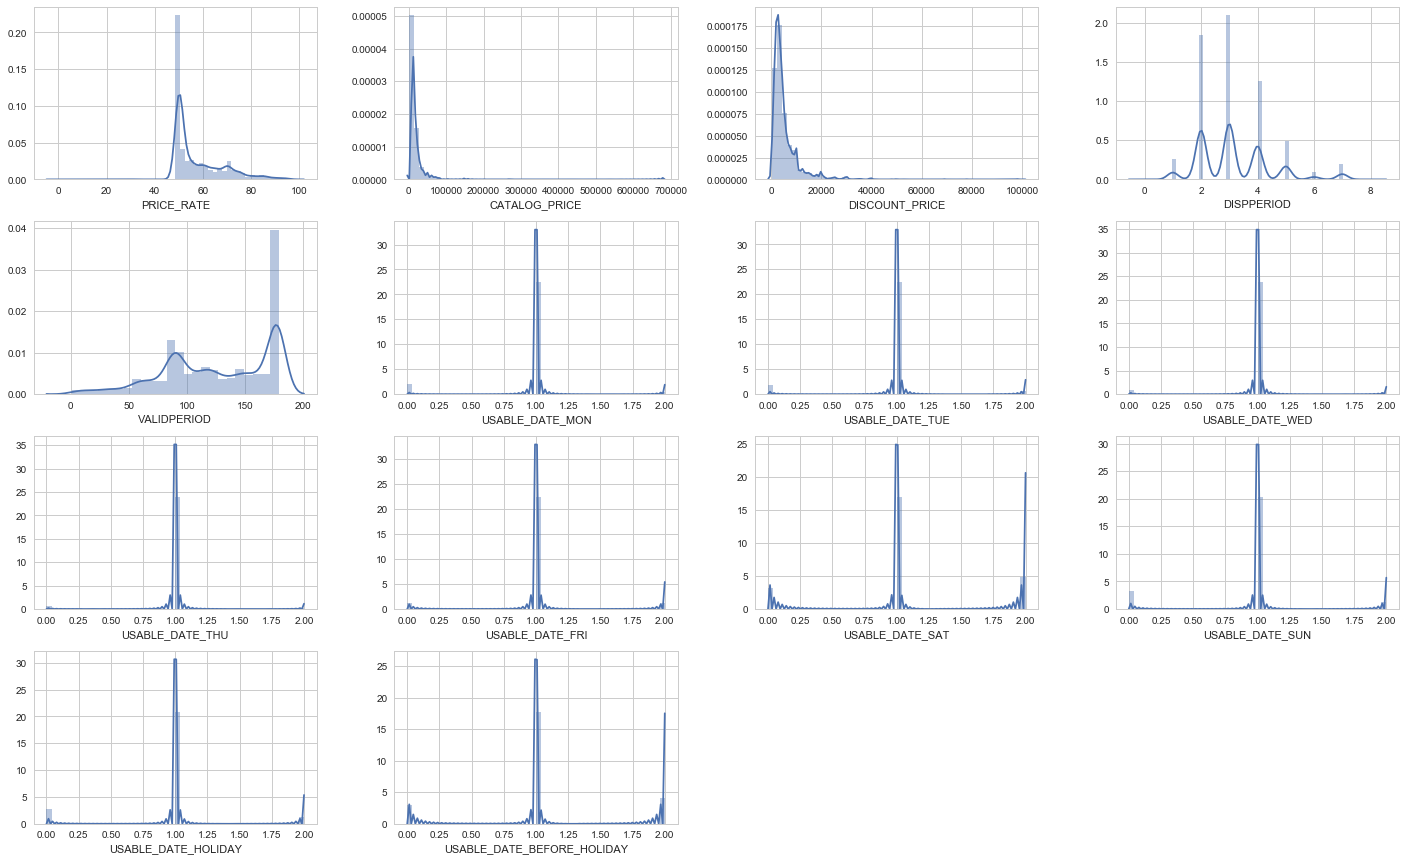

In [15]:
plt.figure(figsize=(20, 15))
for idx, col in enumerate(coupon_numeric):
    if col == 'VALIDPERIOD': 
        plt.subplot(5, 4, idx + 1)
        sns.distplot(filtered_validperiod)
    elif col == 'DISPPERIOD':
        plt.subplot(5, 4, idx + 1)
        sns.distplot(filtered_dispperiod)
    else:
        plt.subplot(5, 4, idx + 1)
        sns.distplot(filtered[col])
plt.tight_layout(pad=2, h_pad=1)
plt.show()

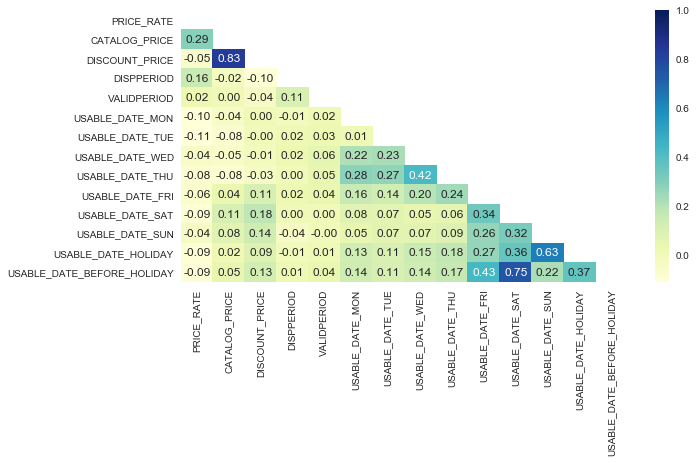

In [16]:
# 카탈로그 price 와 discount price와의 상관관계를 봐야함
# 할인가격(DISCOUNT_PRICE)와 CATALOG_PRICE(정가) 상관관계 높음 -> 가격이 클 수록 할인 가격도 크다 
# 할인율과 DISPPERIOD와의 상관관계도 어느정도 있는듯 0.16(경미하긴 함)
# 유효기간(VALIDPERIOD)와 쿠폰판매기간(DISPPERIOD) 도 어느정도 상관관계가 있음 0.11
# 요일이 인접할 수록 상관관계가 있음
# HOLIDAY와 주말(SAT, SUN)는 상관관계가 매우 큼 -> 브랜드세일 처럼 주말에서부터 HOLIDAY(일명 황금연휴)로 세일했을 가능성이 크며 사용량이 많을 것으로 추저됨(경험상)
corr = filtered.filter(coupon_numeric).corr()
plt.figure(figsize = (10,5))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

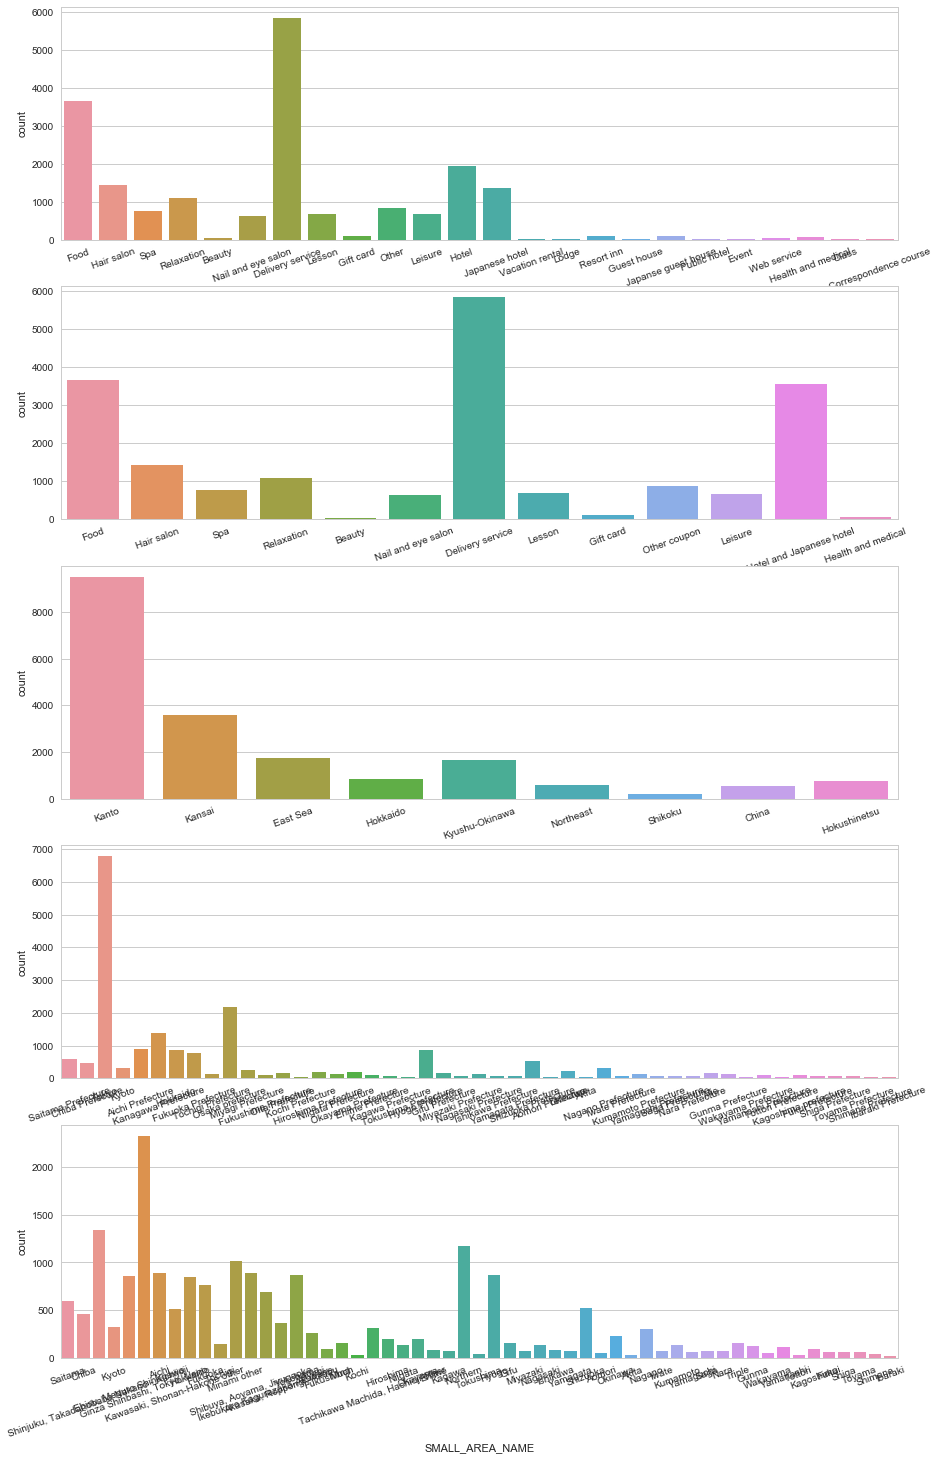

In [17]:
# 음식, 배달서비스, nail, 숙박이 꽤 많음
# 유효기간이 있는 경우가 많긴 함.
plt.figure(figsize = (15, 30))
for idx, col in enumerate(coupon_cat):
    plt.subplot(6, 1, idx + 1)
    g = sns.countplot(coupon_list_train[col])
    g = plt.setp(g.get_xticklabels(), rotation=20) 
plt.show()

카테고리별 할인율

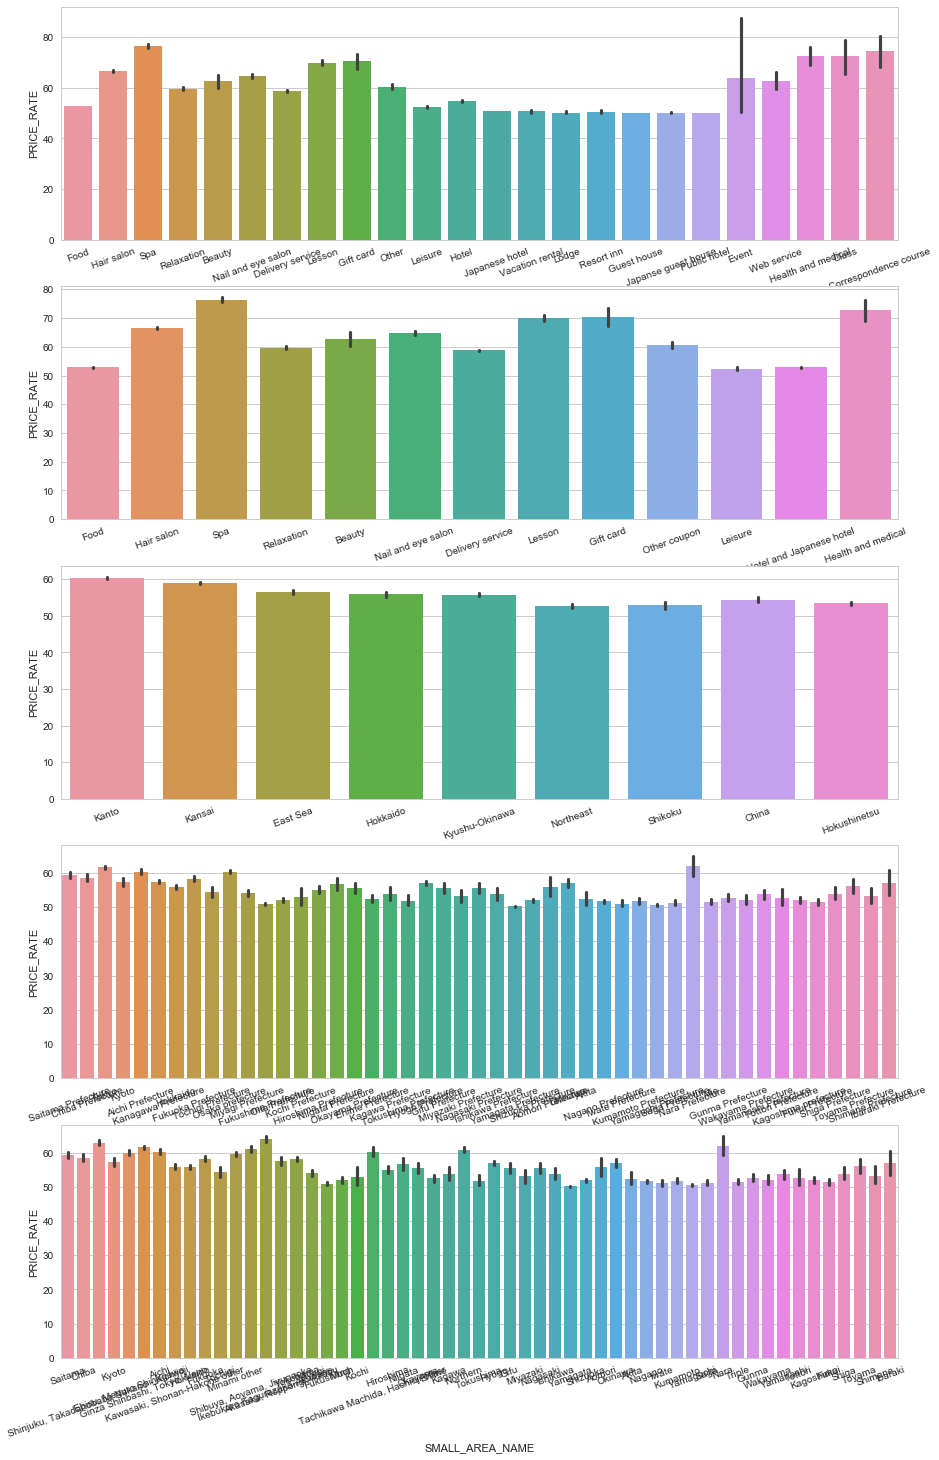

In [18]:
plt.figure(figsize = (15, 30))
for idx, col in enumerate(coupon_cat):
    plt.subplot(6, 1, idx + 1)
    g = sns.barplot(x = coupon_list_train[col], y = coupon_list_train['PRICE_RATE'])
    g = plt.setp(g.get_xticklabels(), rotation=20) 
plt.show()

- 카테고리별 전시기간
Gift card와 Health쪽이 전시기간이 높음

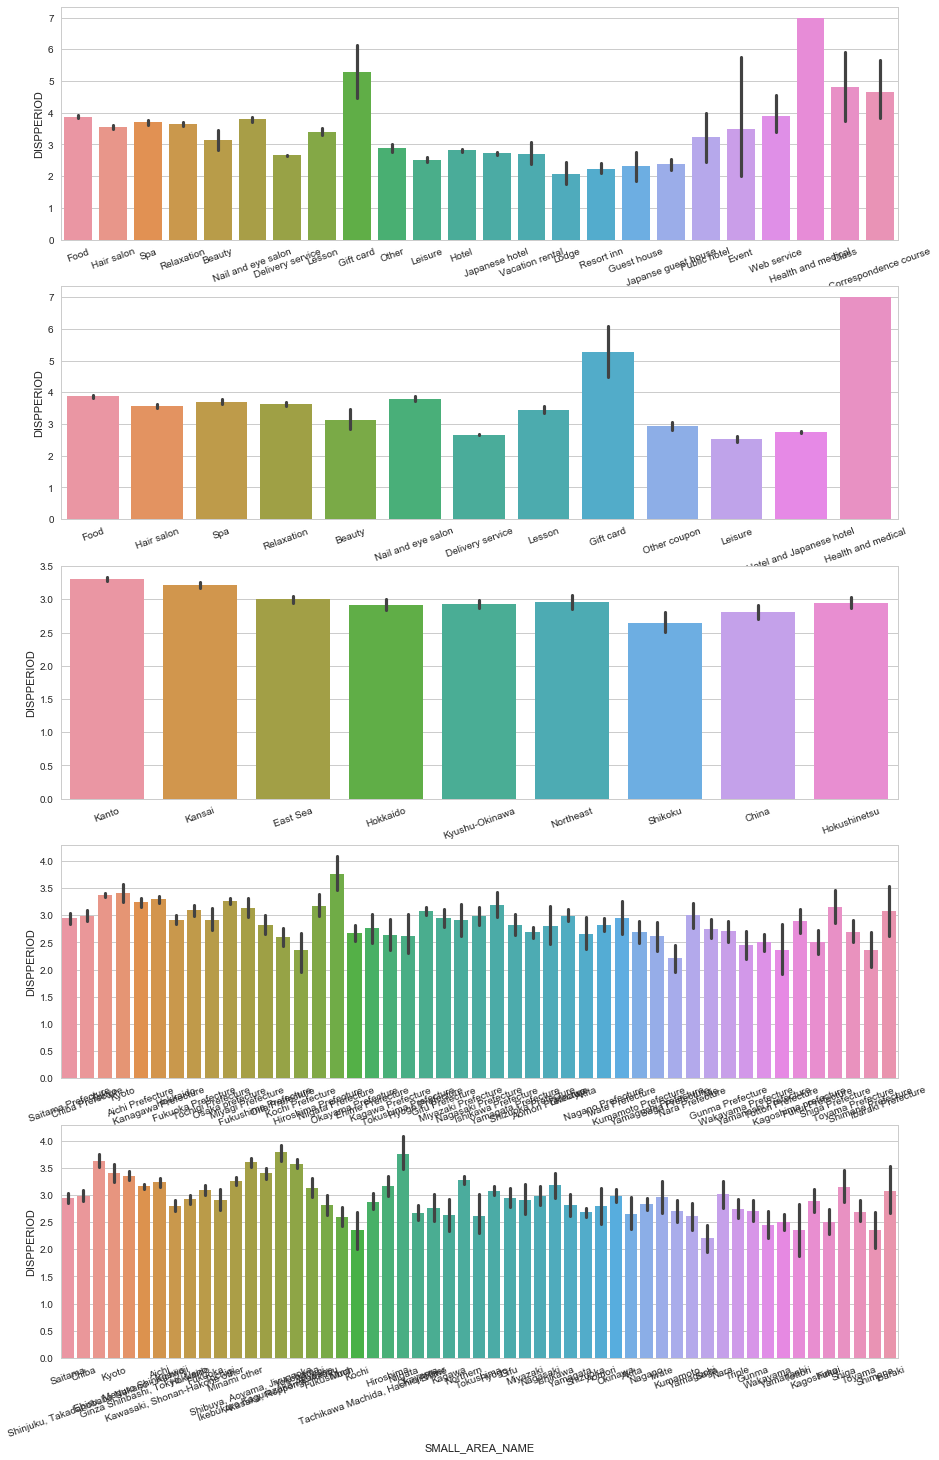

In [19]:
plt.figure(figsize = (15, 30))
for idx, col in enumerate(coupon_cat):
    plt.subplot(6, 1, idx + 1)
    g = sns.barplot(x = coupon_list_train[col], y = coupon_list_train['DISPPERIOD'])
    g = plt.setp(g.get_xticklabels(), rotation=20) 
plt.show()

- 카테고리별 유효기간

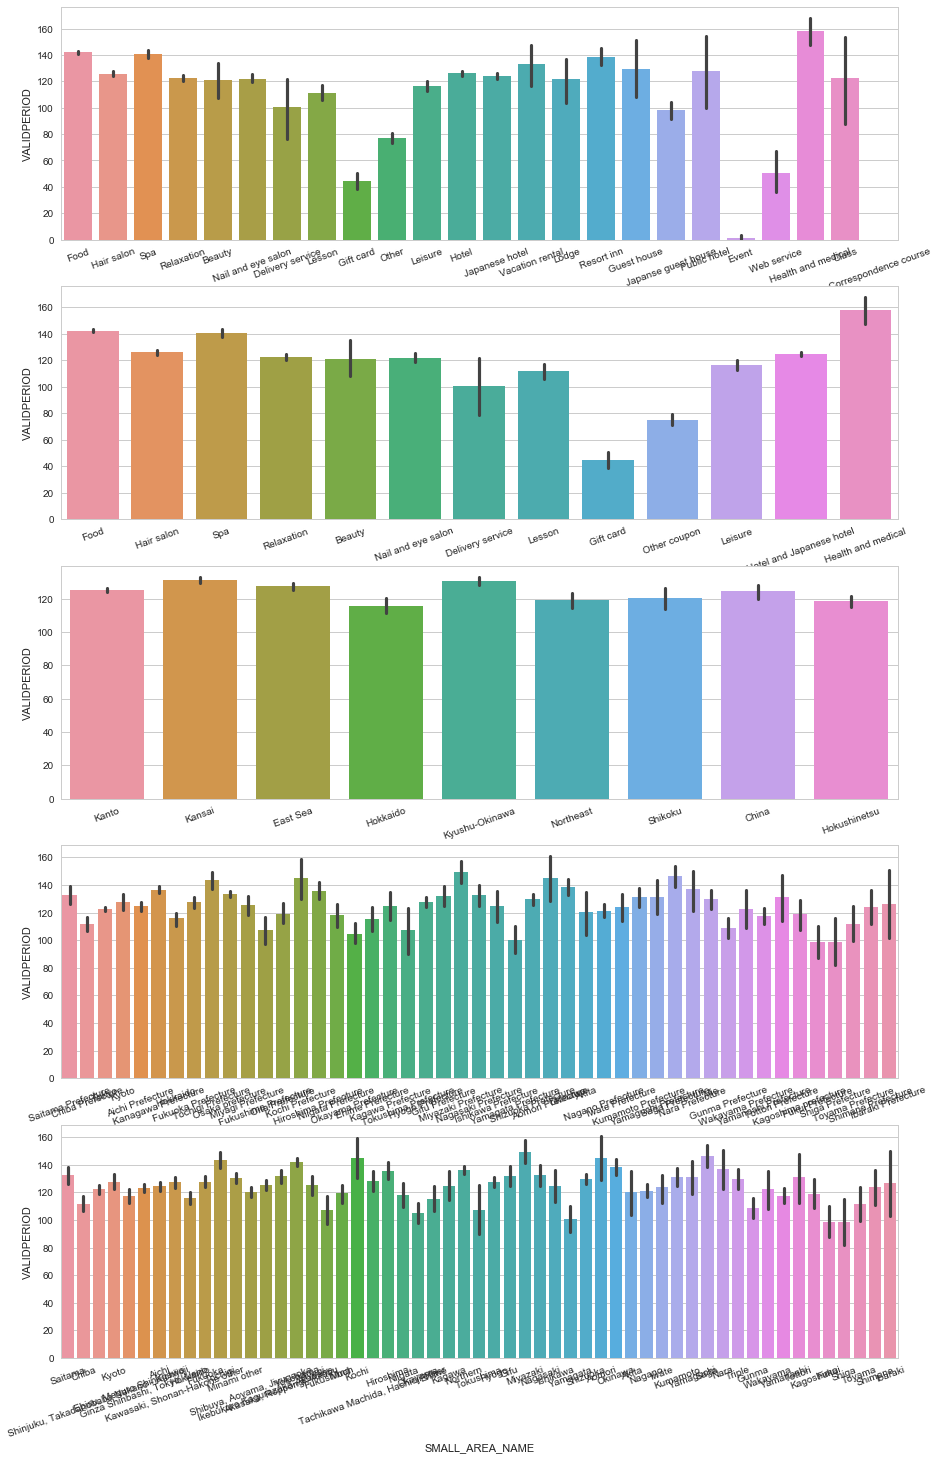

In [20]:
plt.figure(figsize = (15, 30))
for idx, col in enumerate(coupon_cat):
    plt.subplot(6, 1, idx + 1)
    g = sns.barplot(x = coupon_list_train[col], y = coupon_list_train['VALIDPERIOD'])
    g = plt.setp(g.get_xticklabels(), rotation=20) 
plt.show()

###  user_list  분석

In [21]:
user_list['WITHDRAW'] = np.where(user_list['WITHDRAW_DATE'].isna(), '회원', "탈퇴")

In [22]:
print('회원현황: {}'.format(len(user_list[user_list['WITHDRAW'] == '회원']) / len(user_list) * 100))

회원현황: 95.96904647400865


In [23]:
summary_table(user_list).pivot_table(index = ['dtype', 'name'])

act     null   unique
dtype          name                                    
datetime64[ns] REG_DATE       22873.0      0.0  21924.0
               WITHDRAW_DATE    922.0  21951.0    904.0
int64          AGE            22873.0      0.0     66.0
object         PREF_NAME      15617.0   7256.0     48.0
               SEX_ID         22873.0      0.0      2.0
               USER_ID_hash   22873.0      0.0  22873.0
               WITHDRAW       22873.0      0.0      2.0

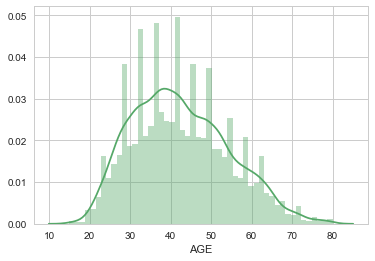

In [24]:
sns.distplot(user_list['AGE'], color='g')

In [25]:
user_cat = [x for x in user_list.columns if user_list[x].dtype == 'object']
user_cat.remove('USER_ID_hash')

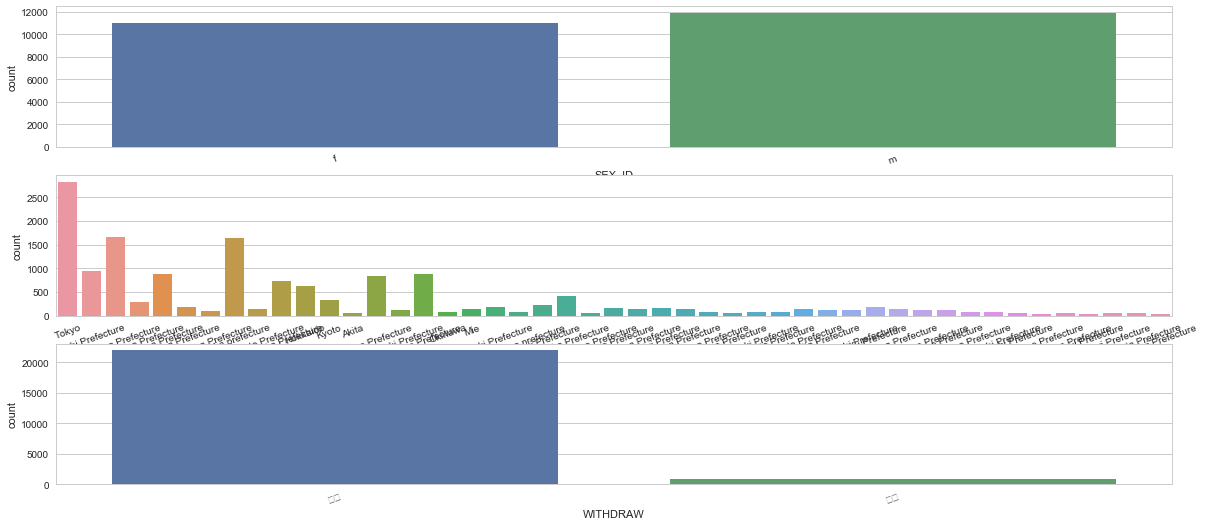

In [26]:

plt.figure(figsize = (20,15))
for idx, col in enumerate(user_cat):
    plt.subplot(5,1, idx+1)
    g = sns.countplot(user_list[col])
    g = plt.setp(g.get_xticklabels(), rotation=20) 
plt.show()


In [27]:
# merge에 앞서 area_train의 PREF_NAME을 Resid_PREF로 변경
# PREF_NAME에서 Prefecture 제거
user_list['PREF_NAME']  = user_list['PREF_NAME'].str.replace(' Prefecture', '')
user_list.rename(columns = {'PREF_NAME': 'Resid_PREF'}, inplace=True)

## detail_train & visit_train

In [28]:
# detail_train에 있는 SMALL_AREA_NAME은 거주지 이므로 이름을 변경
detail_train.rename(columns = {'SMALL_AREA_NAME': 'Resid_SAMLL_AREA'}, inplace=True)
summary_table(detail_train).pivot_table(index=['dtype', 'name'])

act  null    unique
dtype          name                                      
datetime64[ns] I_DATE            168996.0   0.0  130309.0
int64          ITEM_COUNT        168996.0   0.0      32.0
object         COUPON_ID_hash    168996.0   0.0   19368.0
               PURCHASEID_hash   168996.0   0.0  168996.0
               Resid_SAMLL_AREA  168996.0   0.0      55.0
               USER_ID_hash      168996.0   0.0   22782.0

In [29]:
summary_table(visit_train).pivot_table(index=['dtype', 'name'])

act       null     unique
dtype          name                                                
datetime64[ns] I_DATE               2833180.0        0.0  2638744.0
int64          PAGE_SERIAL          2833180.0        0.0      466.0
               PURCHASE_FLG         2833180.0        0.0        2.0
object         PURCHASEID_hash       122389.0  2710791.0   114775.0
               REFERRER_hash        2833180.0        0.0    97319.0
               SESSION_ID_hash      2833180.0        0.0  1046179.0
               USER_ID_hash         2833180.0        0.0    22805.0
               VIEW_COUPON_ID_hash  2833180.0        0.0    32628.0

In [30]:
# 방문한 쿠폰수와 제공된 쿠폰 리스트가 다름 -> 보기만한 쿠폰도 있는듯
# 보기만한 쿠폰의 경우에는 그 고객의 성향을 파악하는데 활용할 수 있음(어떤 분야에 관심을 가지는 고객인가)
print('visit_train unique coupons: {}'.format(len(visit_train.VIEW_COUPON_ID_hash.unique())))
print('coupon_list_train unique coupons: {}'.format(len(coupon_list_train.COUPON_ID_hash.unique())))
print('detail_train unique coupons: {}'.format(len(detail_train.COUPON_ID_hash.unique())))

visit_train unique coupons: 32628
coupon_list_train unique coupons: 19413
detail_train unique coupons: 19368


In [31]:
visit_train['Key'] = visit_train['USER_ID_hash'] + visit_train['VIEW_COUPON_ID_hash']

In [32]:
visit_lookuptable = visit_train.groupby(['Key']).count().reset_index()

In [33]:
visit_lookuptable.columns

Index(['Key', 'PURCHASE_FLG', 'I_DATE', 'PAGE_SERIAL', 'REFERRER_hash',
       'VIEW_COUPON_ID_hash', 'USER_ID_hash', 'SESSION_ID_hash',
       'PURCHASEID_hash'],
      dtype='object')

- detail_train에 visit 정보 매칭

In [34]:
detail_train['Key'] = detail_train['USER_ID_hash'] + detail_train['COUPON_ID_hash']

In [35]:
# visit_train으로 생성한 lookup table에 있는 view , session, referer을 가져 옴
detail_train.insert(2, 'VIEW', detail_train['Key'].map(visit_lookuptable.set_index('Key')['VIEW_COUPON_ID_hash']))
detail_train.insert(2, 'SESSION', detail_train['Key'].map(visit_lookuptable.set_index('Key')['SESSION_ID_hash']))
detail_train.insert(2, 'REFERER', detail_train['Key'].map(visit_lookuptable.set_index('Key')['REFERRER_hash']))

In [36]:
summary_table(detail_train).pivot_table(index=['dtype', 'name'])

act     null    unique
dtype          name                                         
datetime64[ns] I_DATE            168996.0      0.0  130309.0
float64        REFERER           138604.0  30392.0      79.0
               SESSION           138604.0  30392.0      79.0
               VIEW              138604.0  30392.0      79.0
int64          ITEM_COUNT        168996.0      0.0      32.0
object         COUPON_ID_hash    168996.0      0.0   19368.0
               Key               168996.0      0.0  158933.0
               PURCHASEID_hash   168996.0      0.0  168996.0
               Resid_SAMLL_AREA  168996.0      0.0      55.0
               USER_ID_hash      168996.0      0.0   22782.0

## Merge

In [37]:
# coupon 과 user 리스트는 각 고유값으로 이루어져 있는가? -> 그렇다!
coupon_list_train.shape[0] - len(coupon_list_train.COUPON_ID_hash.unique())
user_list.shape[0] - len(user_list.USER_ID_hash.unique())

0

In [38]:
# train_detail & coupon_list_train merge
train = detail_train.merge(coupon_list_train, on = ['COUPON_ID_hash'])

In [39]:
# train & user_list_train merge
train = train.merge(user_list, on=['USER_ID_hash'])

## EDA

In [40]:
summary_table(train).pivot_table(index=['dtype', 'name'])

act      null    unique
dtype          name                                                    
datetime64[ns] DISPEND                     168996.0       0.0     373.0
               DISPFROM                    168996.0       0.0     378.0
               I_DATE                      168996.0       0.0  130309.0
               REG_DATE                    168996.0       0.0   21846.0
               VALIDEND                    103182.0   65814.0     514.0
               VALIDFROM                   103182.0   65814.0     376.0
               WITHDRAW_DATE                 1778.0  167218.0     904.0
float64        REFERER                     138604.0   30392.0      79.0
               SESSION                     138604.0   30392.0      79.0
               USABLE_DATE_BEFORE_HOLIDAY   73139.0   95857.0       4.0
               USABLE_DATE_FRI              73139.0   95857.0       4.0
               USABLE_DATE_HOLIDAY          73139.0   95857.0       4.0
               USABLE_DATE_MON              73139.0   95857.0       4.0
               USABLE_DATE_SAT              73139.0   95857.0       4.0
               USABLE_DATE_SUN              73139.0   95857.0       4.0
               USABLE_DATE_THU              73139.0   95857.0       4.0
               USABLE_DATE_TUE              73139.0   95857.0       4.0
               USABLE_DATE_WED              73139.0   95857.0       4.0
               VALIDPERIOD                 103182.0   65814.0     181.0
               VIEW                        138604.0   30392.0      79.0
int64          AGE                         168996.0       0.0      66.0
               CATALOG_PRICE               168996.0       0.0    2413.0
               DISCOUNT_PRICE              168996.0       0.0    1115.0
               DISPPERIOD                  168996.0       0.0      18.0
               ITEM_COUNT                  168996.0       0.0      32.0
               PRICE_RATE                  168996.0       0.0      71.0
object         CAPSULE_TEXT                168996.0       0.0      24.0
               COUPON_ID_hash              168996.0       0.0   19368.0
               GENRE_NAME                  168996.0       0.0      13.0
               Key                         168996.0       0.0  158933.0
               PURCHASEID_hash             168996.0       0.0  168996.0
               Resid_PREF                  131840.0   37156.0      48.0
               Resid_SAMLL_AREA            168996.0       0.0      55.0
               SEX_ID                      168996.0       0.0       2.0
               SMALL_AREA_NAME             168996.0       0.0      55.0
               USER_ID_hash                168996.0       0.0   22782.0
               VALID                       168996.0       0.0       2.0
               WITHDRAW                    168996.0       0.0       2.0
               ken_name                    168996.0       0.0      47.0
               large_area_name             168996.0       0.0       9.0

In [44]:
train_numeric_list = [x for x in train.columns if train[x].dtype == 'float64' or train[x].dtype == 'int64']

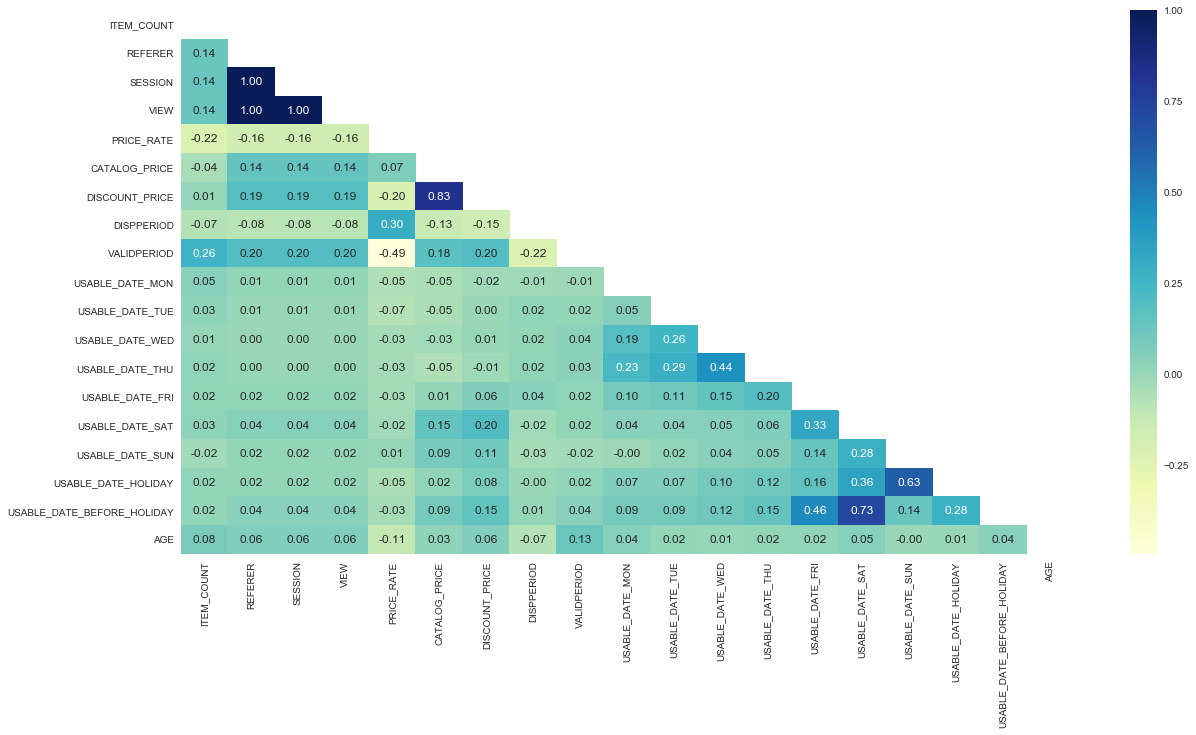

In [49]:
train_corr = train.filter(train_numeric_list).corr()
plt.figure(figsize = (20,10))
mask = np.zeros_like(train_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(train_corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

1) 판매량(ITEM_COUT)는 VIEW와 관련 (당연)있으면서, VALID_PERIOD와 관련이 높았음

2) VIEW가 할인가(DISCOUNT_PRICE)와 연관있음

3) VIEW, SESSION, REFERER은 동일한 것으로 간주해도 되겠음

4) 연령(AGE)와 유효기간(VALIDPERIOD)이 상관관계가 있음 0.13

5) 유효기간(VALIDPERIOD)와 할인율(PRICE_RATE)가 음의 상관관계를 보임(-0.49)

6) 인접한 요일들이 관련이 있다는건 몇일 연속으로 사용가능하게 했을 가능성이 높음(인접 1~2일)

7) Holiday와 주말(금, 토, 일)이 상관관계가 높음. 주말을 활용한 특정기간 할인이 많았음을 보여줌 -> 하지만 판매량(ITEM_COUNT)와 조회(VIEW)에는 직접적인 영향은 못 미친듯